In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, auc, f1_score, recall_score, precision_score, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from textblob import TextBlob
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords

import joblib
import optuna

# Statistical tests
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro

In [2]:
#nltk.download('stopwords')

In [3]:
!ls /kaggle/input

twitter-toxic-tweets


In [4]:
data_path = '/kaggle/input/twitter-toxic-tweets'

In [5]:
def data_size_memory(df):
    print(f'Data Size: {df.shape[0]:,} rows x {df.shape[1]} columns')
    print(f'Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
    print('\nColumn Data Types:')
    print(df.dtypes)


def missing_value_analysis(df):
    missing_stats = pd.DataFrame({
        'Missing Count': df.isnull().sum(),
        'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    
    print('Missing Values Analysis:\n')
    print(missing_stats)


def show_missing_pattern(df):
    fig, ax = plt.subplots(figsize=(8, 4))
    missing_pct = df.isnull().sum() / len(df) * 100
    bars = ax.barh(missing_pct.index, missing_pct.values, color='steelblue')
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('Missing Values by Column')
    ax.set_xlim(0, max(5, missing_pct.max() + 1))
    
    for bar, val in zip(bars, missing_pct.values):
        ax.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()

def statistical_summary(df, features=[]):
    print('Statistical Summary:\n')
    return df.describe() if len(features) == 0 else df[features].describe()


def target_distribution(df, target_col='label'):
    label_counts = df[target_col].value_counts()
    label_pct = df[target_col].value_counts(normalize=True) * 100
    
    print('Target Variable Distribution:')
    print(f'Non-Toxic (0): {label_counts[0]:,} tweets ({label_pct[0]:.2f}%)')
    print(f'Toxic (1):     {label_counts[1]:,} tweets ({label_pct[1]:.2f}%)')
    print(f'\nImbalance Ratio: {label_counts[0] / label_counts[1]:.2f}:1')


    #plt.subplots(figsize=(12, 4))
    plt.subplots(1, 2, figsize=(12, 5))
    colors = ['#2ecc71', '#e74c3c']
    
    plt.subplot(1, 2, 1) 
    #data['label'].value_counts().plot(kind='bar')
    plt.bar(x=['Non-Toxic','Toxic'], height=label_counts, color=colors)
    for i, count in enumerate(label_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.title("Toxic vs Non-Toxic Tweets")
    plt.xlabel("Label")
    plt.ylabel("Count")
    #plt.show()

    plt.subplot(1, 2, 2) 
    #plt.figure(figsize=(5, 5)) # Optional: Adjust figure size
    plt.pie(label_counts, labels=['Non-Toxic', 'Toxic'], autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Distribution of Data Categories')

    plt.tight_layout()
    plt.show()


def add_text_features(df):
    df['char_count'] = df['tweet'].apply(len)
    df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
    df['hashtag_count'] = df['tweet'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
    df['mention_count'] = df['tweet'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
    df['url_count'] = df['tweet'].apply(lambda x: len(re.findall(r'http\S+|www\.\S+', str(x))))
    df['exclamation_count'] = df['tweet'].apply(lambda x: str(x).count('!'))
    df['question_count'] = df['tweet'].apply(lambda x: str(x).count('?'))
    df['uppercase_ratio'] = df['tweet'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(len(str(x)), 1))
    df['avg_word_length'] = df['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
    df['numeric_count'] = df['tweet'].apply(lambda x: sum(1 for c in x if c.isdigit()))

    return df


def distribution_numerical_features(df, feature_cols):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(feature_cols):
        ax = axes[idx]
        ax.hist(df[col], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
        ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.2f}')
        ax.axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[col].median():.2f}')
        ax.set_xlabel(col.replace('_', ' ').title())
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)
        ax.set_title(f'Distribution of {col.replace("_", " ").title()}')
    
    plt.tight_layout()
    plt.show()


def distribution_by_label(df, feature):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(feature):
        ax = axes[idx]
        data_to_plot = [df[df['label'] == 0][col], df[df['label'] == 1][col]]
        bp = ax.boxplot(data_to_plot, labels=['Non-Toxic', 'Toxic'], patch_artist=True)
    
        for patch, color in zip(bp['boxes'], ['#2ecc71', '#e74c3c']):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
        ax.set_ylabel(col.replace('_', ' ').title())
        ax.set_title(f'{col.replace("_", " ").title()} by Label')
    
    plt.tight_layout()
    plt.show()


def feature_stat_comparision(df, feature_cols):
    comparison_data = []

    for col in feature_cols:
        non_toxic = df[df['label'] == 0][col]
        toxic = df[df['label'] == 1][col]
    
        comparison_data.append({
            'Feature': col.replace('_', ' ').title(),
            'Non-Toxic Mean': f'{non_toxic.mean()}',
            'Toxic Mean': f'{toxic.mean()}',
            'Difference': f'{toxic.mean() - non_toxic.mean()}',
            'Pct Change': f'{((toxic.mean() - non_toxic.mean()) / non_toxic.mean() * 100)}%' if non_toxic.mean() != 0 else 'N/A'
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print('Feature Comparison: Toxic vs Non-Toxic Tweets')
    print('=' * 80)
    return comparison_df


def deep_analysis(df, key_features):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, col in enumerate(key_features):
        ax = axes[idx]
        parts = ax.violinplot([df[df['label'] == 0][col], df[df['label'] == 1][col]],
                              positions=[0, 1], showmeans=True, showmedians=True)
    
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(['#2ecc71', '#e74c3c'][i])
            pc.set_alpha(0.7)
    
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Non-Toxic', 'Toxic'])
        ax.set_ylabel(col.replace('_', ' ').title())
        ax.set_title(f'Distribution of {col.replace("_", " ").title()}')
    
    plt.tight_layout()
    plt.show()


def clean_text_for_analysis(text):
    """Basic cleaning for word frequency analysis."""
    text = str(text).lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def get_word_freq(texts, n=30):
    """Get top n most frequent words."""
    stop_words = set(stopwords.words('english'))
    all_words = []
    for text in texts:
        cleaned = clean_text_for_analysis(text)
        words = [w for w in cleaned.split() if w not in stop_words and len(w) > 2]
        all_words.extend(words)
    return Counter(all_words).most_common(n)


def visualize_word_freq(toxic_words, non_toxic_words):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Non-toxic words
    words_nt, counts_nt = zip(*non_toxic_words[:20])
    axes[0].barh(range(len(words_nt)), counts_nt, color='#2ecc71')
    axes[0].set_yticks(range(len(words_nt)))
    axes[0].set_yticklabels(words_nt)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Frequency')
    axes[0].set_title('Top 20 Words in Non-Toxic Tweets')
    
    # Toxic words
    words_t, counts_t = zip(*toxic_words[:20])
    axes[1].barh(range(len(words_t)), counts_t, color='#e74c3c')
    axes[1].set_yticks(range(len(words_t)))
    axes[1].set_yticklabels(words_t)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Frequency')
    axes[1].set_title('Top 20 Words in Toxic Tweets')
    
    plt.tight_layout()
    plt.show()


def calculate_descriptive_stats(series, name):
    stats_dict = {
        'Feature': name,
        'Count': len(series),
        'Mean': series.mean(),
        'Std': series.std(),
        'Min': series.min(),
        '25%': series.quantile(0.25),
        'Median': series.median(),
        '75%': series.quantile(0.75),
        'Max': series.max(),
        'IQR': series.quantile(0.75) - series.quantile(0.25),
        'Range': series.max() - series.min(),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis()
    }
    return stats_dict


def outlier_analysis(series, method='iqr'):
    """Detect outliers using IQR or Z-score method."""
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (series < lower_bound) | (series > upper_bound)
    else:
        z_scores = np.abs(stats.zscore(series))
        outliers = z_scores > 3
    return outliers


def disp_correlation(df, feature_cols):
    # Correlation matrix
    corr_cols = feature_cols + ['label']
    corr_matrix = df[corr_cols].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, square=True, linewidths=0.5)
    plt.title('Correlation Matrix of Engineered Features')
    plt.tight_layout()
    plt.show()

    return corr_matrix


def check_multicollinearity(feature_cols, corr_matrix):
    print('\nStrongly Correlated Feature Pairs (|r| > 0.5):')
    print('=' * 50)
    
    strong_correlations = []
    for i in range(len(feature_cols)):
        for j in range(i+1, len(feature_cols)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_correlations.append((feature_cols[i], feature_cols[j], corr_val))
                print(f'{feature_cols[i]} <-> {feature_cols[j]}: {corr_val:.3f}')
    
    if not strong_correlations:
        print('No feature pairs with |r| > 0.5 found.')


def check_mann_whitney_test(df, feature_cols):
    print('Mann-Whitney U Tests: Do features differ between Toxic and Non-Toxic tweets?')
    print('=' * 80)
    print(f'{"Feature":25s} {"U-Statistic":>15s} {"P-Value":>15s} {"Significant?":>15s}')
    print('-' * 80)
    
    test_results = []
    
    for col in feature_cols:
        non_toxic = df[df['label'] == 0][col]
        toxic = df[df['label'] == 1][col]
    
        stat, p_value = mannwhitneyu(non_toxic, toxic, alternative='two-sided')
        significant = 'Yes' if p_value < 0.05 else 'No'
    
        print(f'{col:25s} {stat:>15,.0f} {p_value:>15.2e} {significant:>15s}')
    
        test_results.append({
            'feature': col,
            'statistic': stat,
            'p_value': p_value,
            'significant': significant
        })


def shapiro_wilk_normality_tests(df, feature_cols):
    print('\nShapiro-Wilk Normality Tests (on 5000-sample subset):')
    print('=' * 60)
    
    sample = df.sample(n=5000, random_state=42)
    
    for col in feature_cols[:4]:
        stat, p_value = shapiro(sample[col])
        normal = 'Yes' if p_value > 0.05 else 'No'
        print(f'{col:25s}: W={stat:.4f}, p={p_value:.2e}, Normal? {normal}')



def preprocess_data(text):
    # Lowercase conversion
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove @mentions (anonymized anyway)
    text = re.sub(r'@\w+', '', text)

    # Remove special characters but keep hashtag words
    text = re.sub(r'#', '', text)

    # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    tokens = text.split()

    # Remove stopwords
    STOP_WORDS = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in STOP_WORDS and len(token) > 2]
    return ' '.join(tokens)


def plot_confusion_matrix(y_true, y_pred, labels):
    cm_baseline = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels,
                ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Baseline Model: Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    tn, fp, fn, tp = cm_baseline.ravel()
    print(f'\nConfusion Matrix Interpretation:')
    print(f'True Negatives (correct non-toxic):  {tn:,}')
    print(f'False Positives (non-toxic marked toxic): {fp:,}')
    print(f'False Negatives (toxic marked non-toxic): {fn:,}')
    print(f'True Positives (correct toxic): {tp:,}')



def run_models(models, X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []
    print(f'Model Comparison ({n_splits}-Fold Stratified Cross-Validation)')
    print('=' * 80)

    for name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1)
        cv_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

        results.append({
            'Model': name,
            'CV F1 Mean': cv_scores.mean(),
            'CV F1 Std': cv_scores.std(),
            'CV Accuracy Mean': cv_accuracy.mean(),
            'CV Accuracy Std': cv_accuracy.std()
        })

        print(f'  F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})')
        print(f'  Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std()*2:.4f})')

    results_df = pd.DataFrame(results).sort_values('CV F1 Mean', ascending=False)
    return results_df


def visualize_model_metrics(results_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(results_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df['CV F1 Mean'], width,
                   yerr=results_df['CV F1 Std'], label='F1 Score', color='steelblue', capsize=5)
    bars2 = ax.bar(x + width/2, results_df['CV Accuracy Mean'], width,
                   yerr=results_df['CV Accuracy Std'], label='Accuracy', color='coral', capsize=5)
    
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Model'], rotation=15, ha='right')
    ax.legend()
    ax.set_ylim(0.5, 1.0)
    
    plt.tight_layout()
    plt.show()


def objective_optuna(trial, X, y):
    solver =  trial.suggest_categorical("solver", ["liblinear", "saga"])
    penalty = trial.suggest_categorical("penalty",["l1", "l2"] if solver in ["liblinear", "saga"] else ["l2"], )
    C = trial.suggest_float("C", 1e-4, 100.0, log=True)
    #class_weight = trial.suggest_categorical("class_weight", [None, "balanced"] )
    max_iter = trial.suggest_int("max_iter", 100, 5000)

    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        #class_weight=class_weight,
        max_iter=max_iter,
        random_state=42,
        n_jobs=-1,
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    score = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    ).mean()

    return score


def model_tuning(X, y, n_trials=5):
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_optuna(trial, X, y),
        n_trials=n_trials,
        show_progress_bar=True
    )

    return study


#### Load the Data

In [6]:
data = pd.read_csv(os.path.join(data_path, "twitter_toxic_tweets.csv"), usecols=['label', 'tweet'])
data_size_memory(data)

Data Size: 31,962 rows x 2 columns
Memory Usage: 4.48 MB

Column Data Types:
label     int64
tweet    object
dtype: object


#### Display top 5 rows

In [7]:
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


#### Calculating Missing Values

In [8]:
missing_value_analysis(data)

empty_tweets = (data['tweet'].str.strip() == '').sum()
print(f'\nEmpty tweets (whitespace only): {empty_tweets}')

Missing Values Analysis:

       Missing Count  Missing Percentage
label              0                 0.0
tweet              0                 0.0

Empty tweets (whitespace only): 0


#### See What is missing pattern

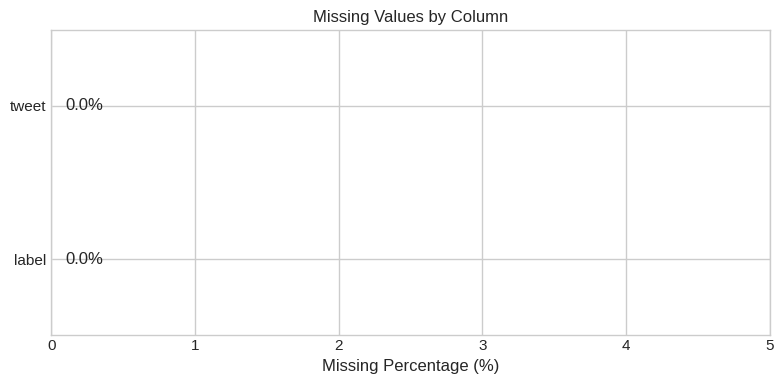

In [9]:
show_missing_pattern(data)

Insight: There is no missing value

#### Statistical summary

In [10]:
statistical_summary(data)

Statistical Summary:



,label
count,31962.000000
mean,0.070146
std,0.255397
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


#### Let's explore target varibale distribution

Target Variable Distribution:
Non-Toxic (0): 29,720 tweets (92.99%)
Toxic (1):     2,242 tweets (7.01%)

Imbalance Ratio: 13.26:1


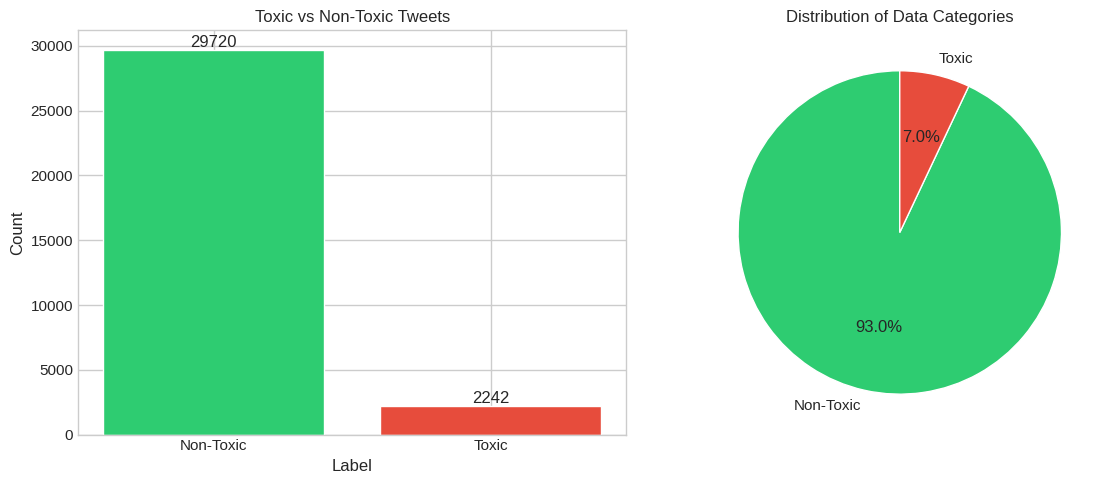

In [11]:
target_distribution(data, 'label')

In [12]:
data['label'].value_counts(normalize=True)

label
0    0.929854
1    0.070146
Name: proportion, dtype: float64

#### Insight

- As you can see clearly, We have imbalanced data here. 
- `Toxic` tweets are 7% and `Non-Toxic` are 92.98%.

#### Add some features for analysis

- char_count,
- word_count,
- hashtag_count,
- mention_count,
- url_count,
- exclamation_count,
- question_count,
- uppercase_ratio,
- avg_word_length

In [13]:
data = add_text_features(data)

data.head()

,label,tweet,char_count,word_count,hashtag_count,mention_count,url_count,exclamation_count,question_count,uppercase_ratio,avg_word_length,numeric_count
0,0,@user when a father is dysfunctional and is s...,102,18,1,1,0,0,0,0.0,4.555556,0
1,0,@user @user thanks for #lyft credit i can't us...,122,19,3,2,0,0,0,0.0,5.315789,0
2,0,bihday your majesty,21,3,0,0,0,0,0,0.0,5.666667,0
3,0,#model i love u take with u all the time in ...,86,14,1,0,0,3,0,0.0,4.928571,0
4,0,factsguide: society now #motivation,39,4,1,0,0,0,0,0.0,8.000000,0


#### statistical summary

In [14]:
feature_cols = ['char_count', 'word_count', 'hashtag_count', 'mention_count',
                'url_count', 'exclamation_count', 'question_count', 'uppercase_ratio', 'avg_word_length']

statistical_summary(data, feature_cols)

Statistical Summary:



,char_count,word_count,hashtag_count,mention_count,url_count,exclamation_count,question_count,uppercase_ratio,avg_word_length
count,31962.000000,31962.00000,31962.000000,31962.000000,31962.000000,31962.000000,31962.000000,31962.000000,31962.000000
mean,84.739628,13.15872,2.387085,0.549747,0.000188,0.458357,0.081347,0.000202,5.593463
std,29.455749,5.47815,2.501881,0.983729,0.013700,1.105819,0.363733,0.004253,1.945719
min,11.000000,3.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,63.000000,9.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.529412
50%,88.000000,13.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.200000
75%,108.000000,17.00000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.200000
max,274.000000,34.00000,20.000000,11.000000,1.000000,58.000000,12.000000,0.335714,81.333333


#### Distribution of numerical features

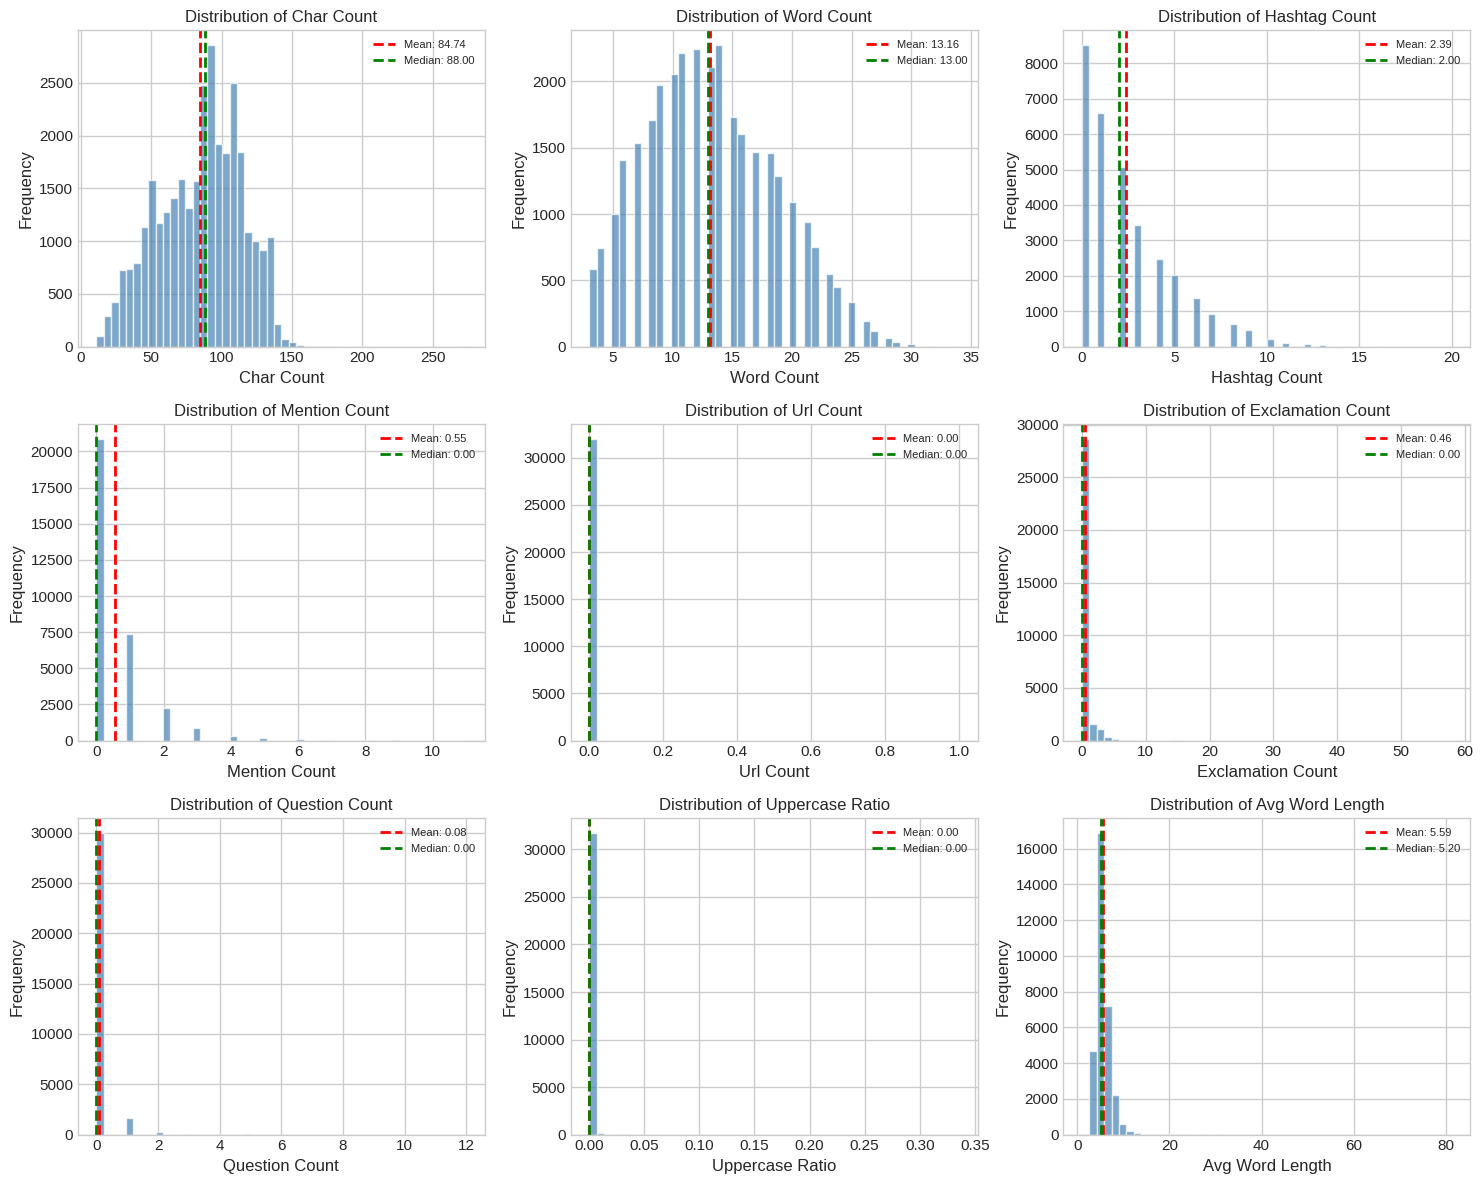

In [15]:
distribution_numerical_features(data, feature_cols)

#### Insight

- `Char Count`
    - Most of the tweets have betwwen `50` to `150` char count.
    - Mean of `Char Count` is 84, Median is 88
- `Word Count`
    - Most of the tweets have betwwen `13.16` to `13` word count.
    - Mean of `Word Count` is 84, Median is 88
- `Hashtag Count`
    - Most of the tweets have 2 Hash tags.
    - There are very few cases where tweet have around 10 Hash tags
- `Mention Count`
    - Most of the tweets have 0 mention count.
    - However there are tweets which have 2, 4 mentions
- `Exclamation Count`
    - Most of the tweets have 0 Exclamation.
    - There are some tweets which have 2 or 3 Exclamation.
- `Question Count`
    - Most of the tweets have 0 Question.
- `Uppercase Ratio`
    - Most of the tweets have low uppercase.


#### Distribution by target variable

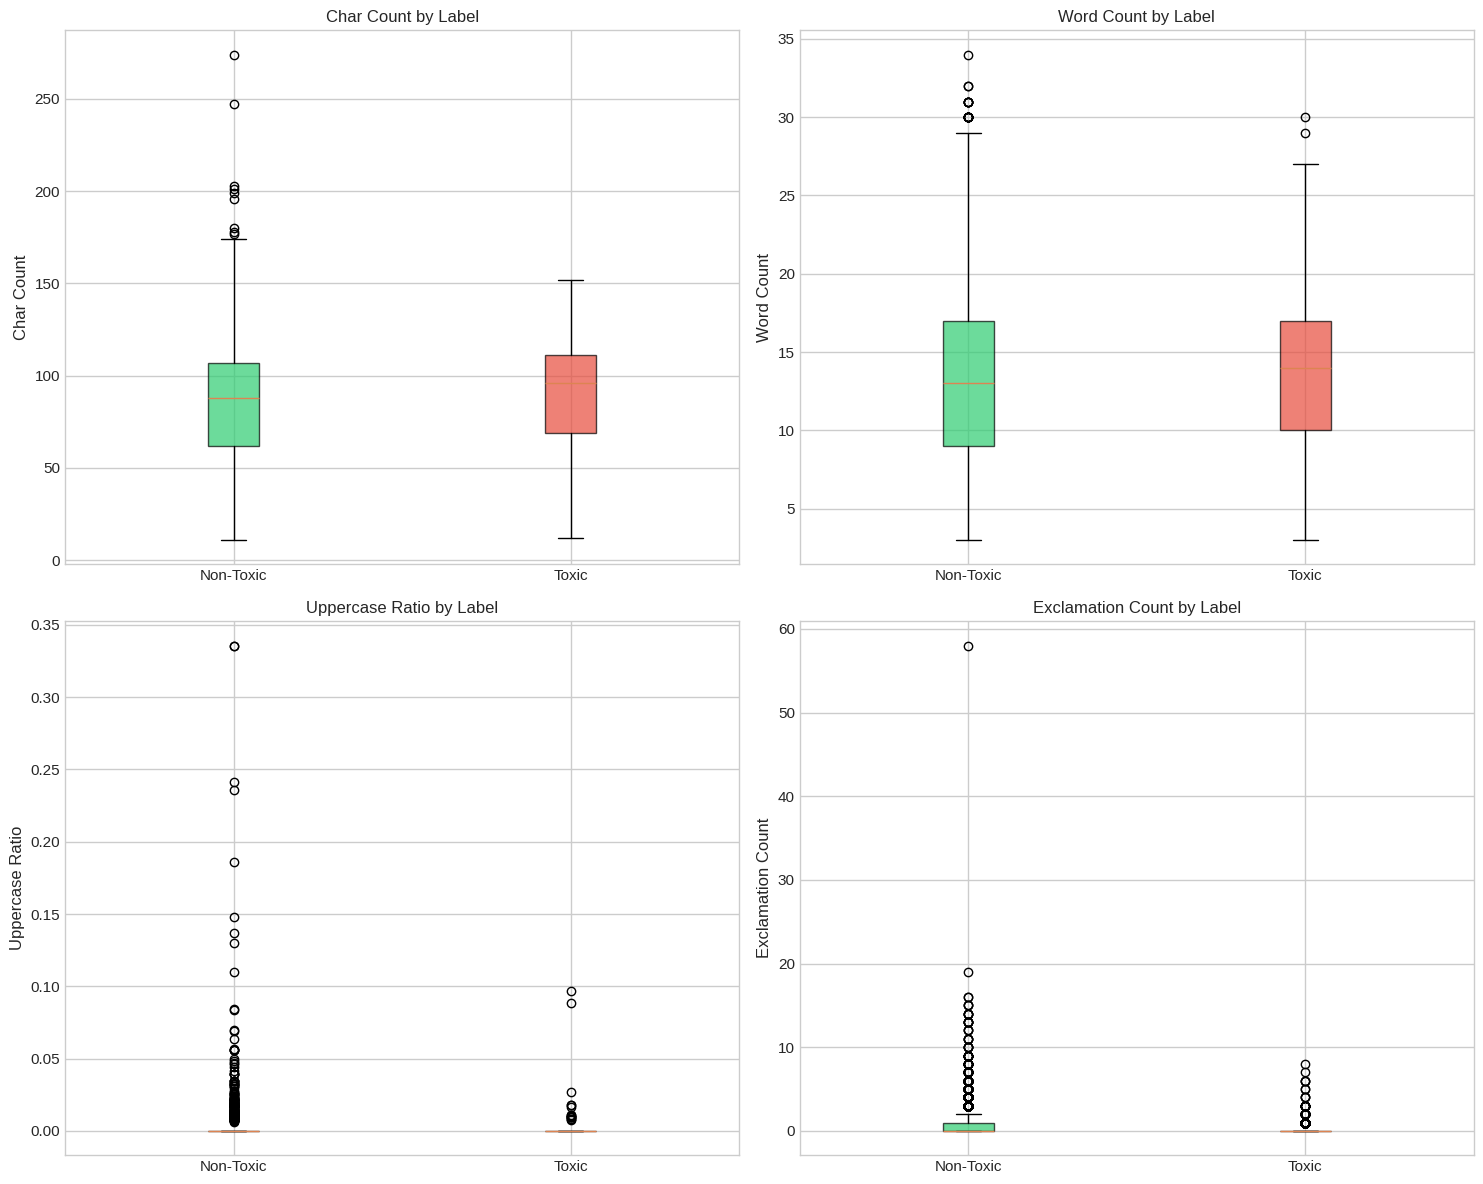

In [16]:
distribution_by_label(data, ['char_count', 'word_count', 'uppercase_ratio', 'exclamation_count'])

#### Insights:

- Toxic tweets have less average count in terms of `word count` and `character count`.
- Toxic tweets have less Uppercase ratio
- Toxic tweets have less uses of exclamation

#### Let's compare features

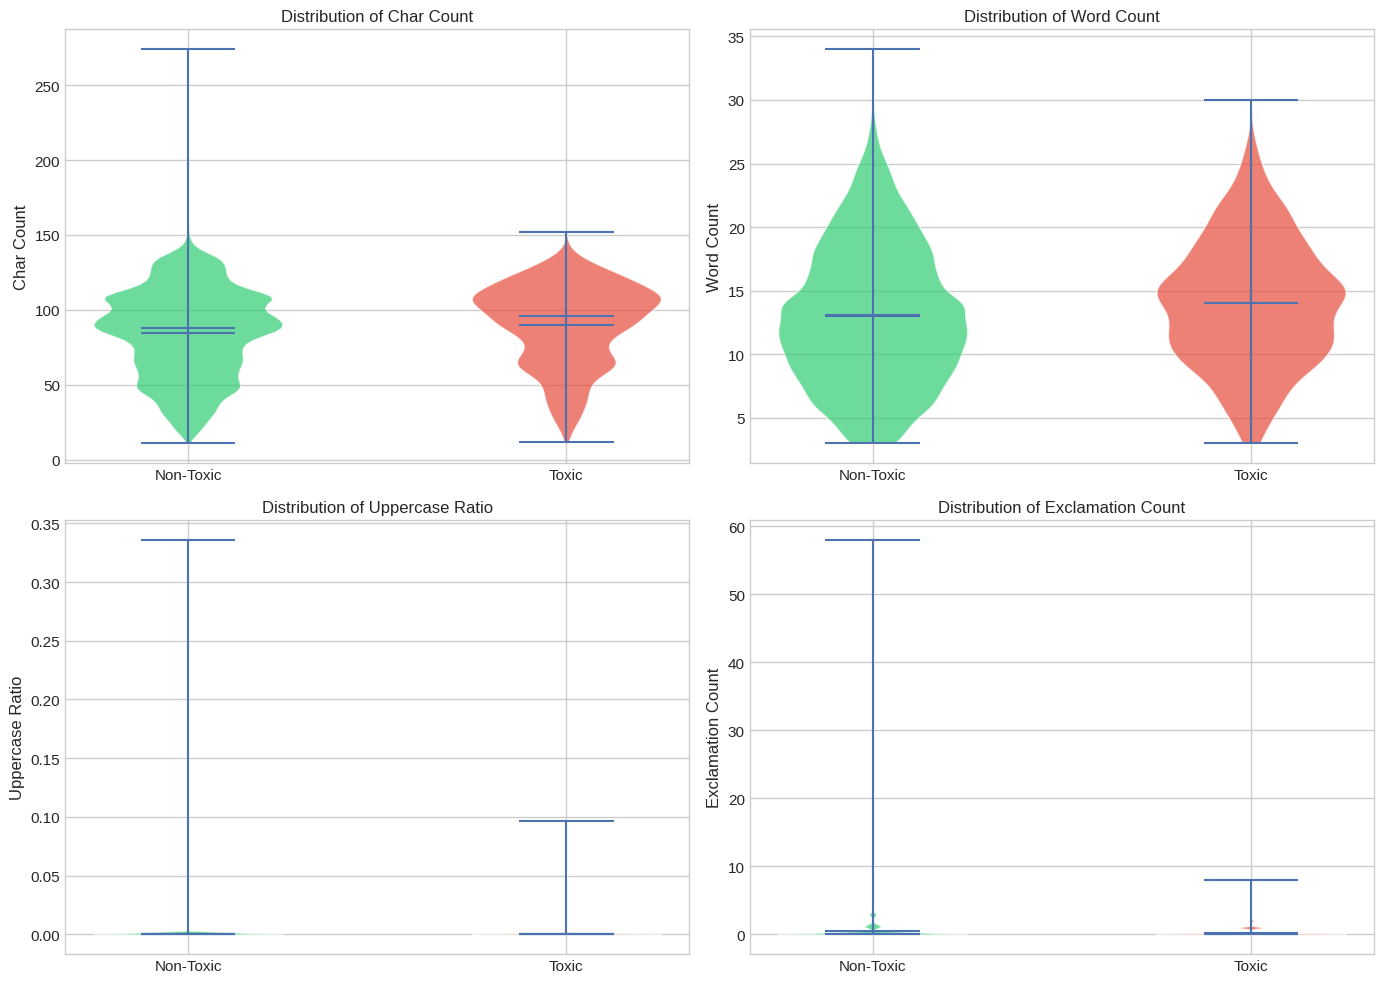

In [17]:
key_features = ['char_count', 'word_count', 'uppercase_ratio', 'exclamation_count']
deep_analysis(data, key_features)

In [18]:
#feature_stat_comparision(data, feature_cols)

#### Let explore word frequency based on target variable

In [19]:
non_toxic_words = get_word_freq(data[data['label'] == 0]['tweet'])
toxic_words = get_word_freq(data[data['label'] == 1]['tweet'])

print('Top 20 Words in Non-Toxic Tweets:')
print(non_toxic_words[:20])
print('\nTop 20 Words in Toxic Tweets:')
print(toxic_words[:20])

Top 20 Words in Non-Toxic Tweets:
[('love', 2700), ('day', 2281), ('happy', 1679), ('amp', 1325), ('life', 1121), ('time', 1104), ('today', 996), ('positive', 931), ('thankful', 925), ('new', 917), ('like', 914), ('get', 885), ('bihday', 856), ('good', 817), ('cant', 776), ('people', 770), ('one', 735), ('see', 733), ('fathers', 724), ('smile', 714)]

Top 20 Words in Toxic Tweets:
[('amp', 283), ('trump', 199), ('libtard', 149), ('like', 139), ('white', 138), ('black', 131), ('racist', 103), ('politics', 97), ('people', 95), ('allahsoil', 92), ('liberal', 82), ('might', 77), ('sjw', 74), ('women', 72), ('new', 71), ('obama', 68), ('retweet', 67), ('dont', 67), ('hate', 66), ('racism', 64)]


#### Visualize word frequency

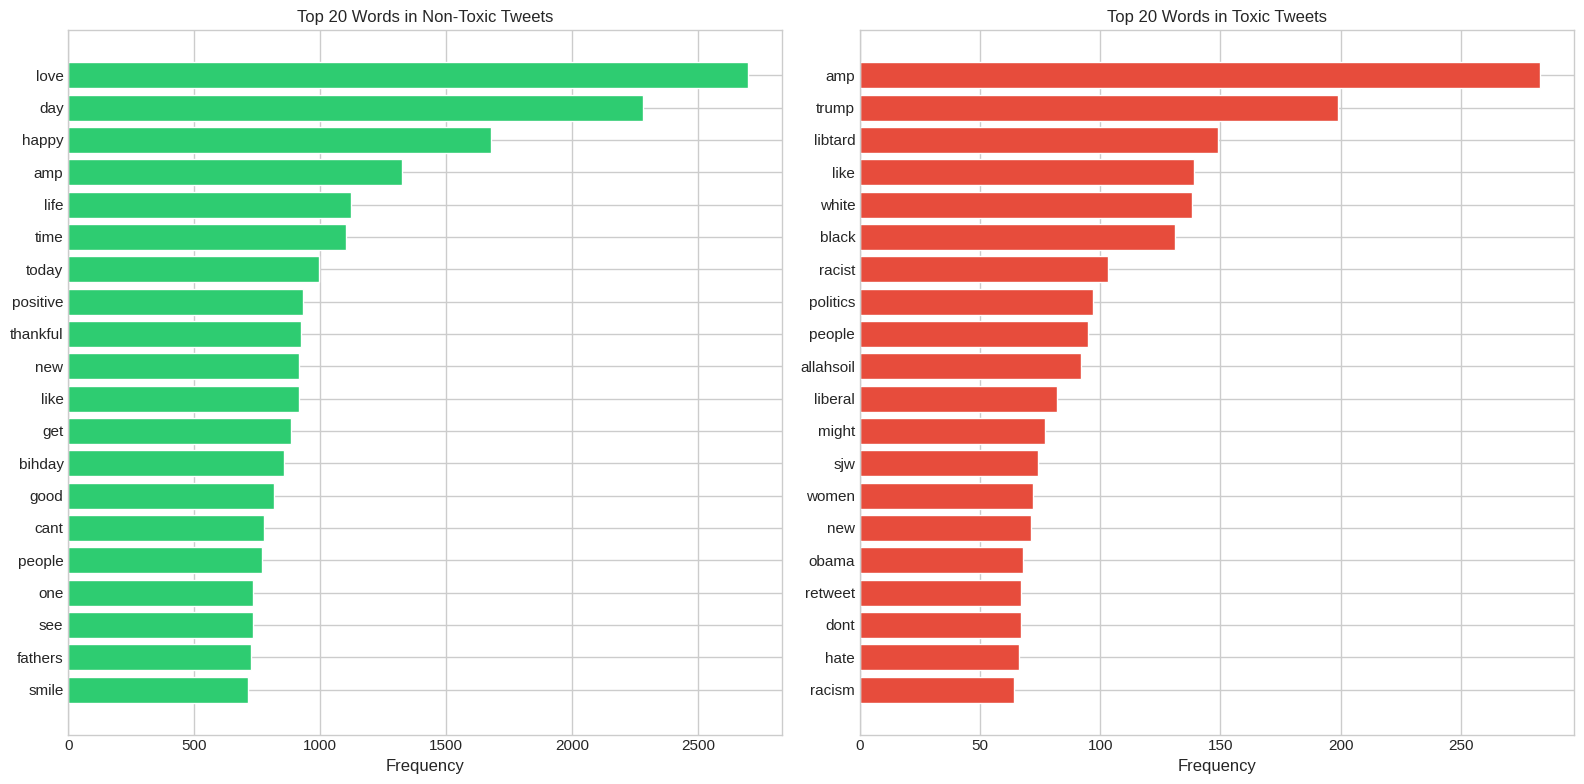

In [20]:
visualize_word_freq(toxic_words, non_toxic_words)

#### Insights:

- Non-Toxic Content: Features a positive emotional tone centered on daily life and enthusiasm (e.g., "day," "good," "new").

- Toxic Content: Primarily politically charged. The prevalence of race-related and inflammatory social terms indicates that toxicity stems from political polarization rather than personal beefs.

#### Explore descriptive stats

In [21]:
stats_list = [calculate_descriptive_stats(data[col], col) for col in feature_cols]
stats_df = pd.DataFrame(stats_list)

print('Comprehensive Descriptive Statistics:')
print('=' * 100)
stats_df.round(3)

Comprehensive Descriptive Statistics:


,Feature,Count,Mean,Std,Min,25%,Median,75%,Max,IQR,Range,Skewness,Kurtosis
0,char_count,31962,84.740,29.456,11.0,63.000,88.0,108.0,274.000,45.000,263.000,-0.229,-0.586
1,word_count,31962,13.159,5.478,3.0,9.000,13.0,17.0,34.000,8.000,31.000,0.317,-0.486
2,hashtag_count,31962,2.387,2.502,0.0,0.000,2.0,4.0,20.000,4.000,20.000,1.361,1.906
3,mention_count,31962,0.550,0.984,0.0,0.000,0.0,1.0,11.000,1.000,11.000,2.852,12.186
4,url_count,31962,0.000,0.014,0.0,0.000,0.0,0.0,1.000,0.000,1.000,72.969,5322.833
5,exclamation_count,31962,0.458,1.106,0.0,0.000,0.0,0.0,58.000,0.000,58.000,8.016,253.645
6,question_count,31962,0.081,0.364,0.0,0.000,0.0,0.0,12.000,0.000,12.000,7.180,89.520
7,uppercase_ratio,31962,0.000,0.004,0.0,0.000,0.0,0.0,0.336,0.000,0.336,50.789,3314.710
8,avg_word_length,31962,5.593,1.946,1.0,4.529,5.2,6.2,81.333,1.671,80.333,7.064,133.389


#### Feature-target correlations ranked

In [22]:
corr_matrix = data[feature_cols + ['label']].corr()
target_corr = corr_matrix['label'].drop('label').sort_values(key=abs, ascending=False)

print('Feature Correlations with Target (Toxicity):')
print('=' * 50)
for feat, corr in target_corr.items():
    direction = 'positive' if corr > 0 else 'negative'
    strength = 'weak' if abs(corr) < 0.1 else 'moderate' if abs(corr) < 0.3 else 'strong'
    print(f'{feat:20s}: {corr:+.4f} ({strength} {direction})')

Feature Correlations with Target (Toxicity):
mention_count       : +0.0785 (weak positive)
exclamation_count   : -0.0620 (weak negative)
question_count      : +0.0528 (weak positive)
char_count          : +0.0508 (weak positive)
word_count          : +0.0448 (weak positive)
hashtag_count       : -0.0273 (weak negative)
avg_word_length     : -0.0121 (weak negative)
url_count           : -0.0038 (weak negative)
uppercase_ratio     : -0.0028 (weak negative)


#### Check for multicollinearity

In [23]:
check_multicollinearity(feature_cols, corr_matrix)


Strongly Correlated Feature Pairs (|r| > 0.5):
char_count <-> word_count: 0.864


#### Preprocessing tweets

In [24]:
data['clean_tweet'] = data['tweet'].apply(preprocess_data)

print('\nPreprocessing Examples:')
print('=' * 80)
for idx in [0, 5, 10]:
    print(f'Original:  {data.iloc[idx]["tweet"][:80]}...')
    print(f'Cleaned:   {data.iloc[idx]["clean_tweet"][:80]}...')
    print('-' * 80)


Preprocessing Examples:
Original:   @user when a father is dysfunctional and is so selfish he drags his kids into h...
Cleaned:   father dysfunctional selfish drags kids dysfunction run...
--------------------------------------------------------------------------------
Original:  [2/2] huge fan fare and big talking before they leave. chaos and pay disputes wh...
Cleaned:   huge fan fare big talking leave chaos pay disputes get allshowandnogo...
--------------------------------------------------------------------------------
Original:   â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in m...
Cleaned:   ireland consumer price index mom climbed previous may blog silver gold forex...
--------------------------------------------------------------------------------


In [25]:
empty_after_cleaning = (data['clean_tweet'].str.strip() == '').sum()
print(f'Tweets empty after cleaning: {empty_after_cleaning}')

# Handle empty tweets by replacing with placeholder
data['clean_tweet'] = data['clean_tweet'].replace('', 'empty')

Tweets empty after cleaning: 44


#### Spliting data

In [26]:
X_text = data['clean_tweet']
y = data['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {len(X_train_text):,} samples')
print(f'Test set: {len(X_test_text):,} samples')
print(f'\nTraining class distribution:')
print(y_train.value_counts(normalize=True).round(3))

Training set: 25,569 samples
Test set: 6,393 samples

Training class distribution:
label
0    0.93
1    0.07
Name: proportion, dtype: float64


#### Creating features using TfidfVectorizer

In [27]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f'TF-IDF Feature Matrix Shape: {X_train_tfidf.shape}')
print(f'Vocabulary Size: {len(tfidf_vectorizer.vocabulary_):,} terms')
print(f'Sparsity: {100 * (1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.2f}%')

TF-IDF Feature Matrix Shape: (25569, 6708)
Vocabulary Size: 6,708 terms
Sparsity: 99.90%


#### Creating LogisticRegression model

In [28]:
baseline_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train_tfidf, y_train)

y_pred_baseline = baseline_model.predict(X_test_tfidf)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_tfidf)[:, 1]

print('Baseline Model: Logistic Regression')
print('=' * 60)
print(f'Accuracy:  {accuracy_score(y_test, y_pred_baseline):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_baseline):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_baseline):.4f}')
print(f'F1 Score:  {f1_score(y_test, y_pred_baseline):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_baseline):.4f}')

Baseline Model: Logistic Regression
Accuracy:  0.9251
Precision: 0.4789
Recall:    0.7835
F1 Score:  0.5944
ROC-AUC:   0.9432


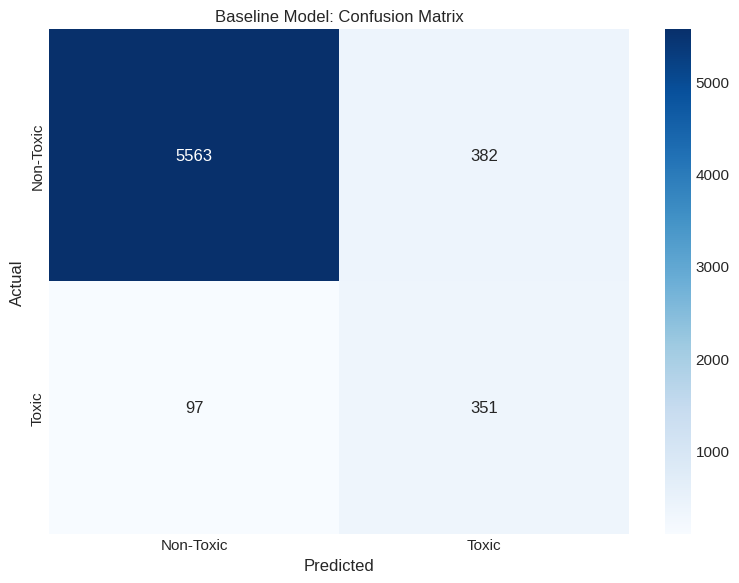


Confusion Matrix Interpretation:
True Negatives (correct non-toxic):  5,563
False Positives (non-toxic marked toxic): 382
False Negatives (toxic marked non-toxic): 97
True Positives (correct toxic): 351


In [29]:
plot_confusion_matrix(y_test, y_pred_baseline, ['Non-Toxic', 'Toxic'])

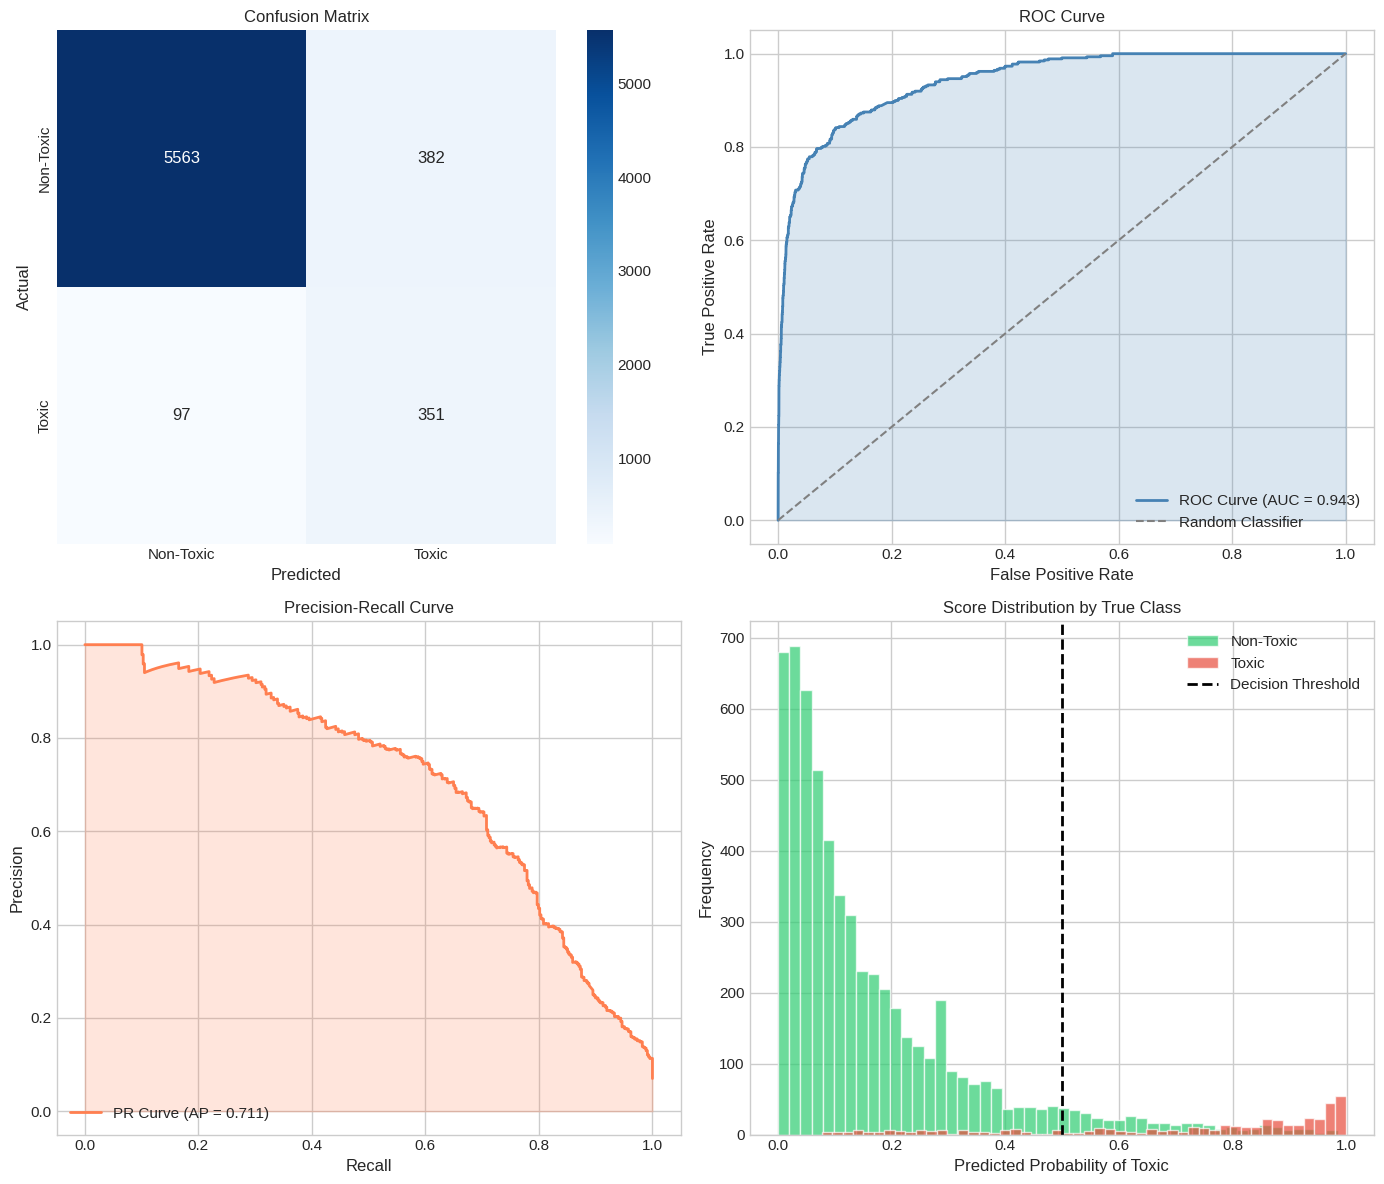

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

cm_final = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'],
            ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Confusion Matrix')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_baseline)
auc_score = roc_auc_score(y_test, y_pred_proba_baseline)
axes[0, 1].plot(fpr, tpr, color='steelblue', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
axes[0, 1].fill_between(fpr, tpr, alpha=0.2, color='steelblue')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend(loc='lower right')

# 3. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_baseline)
ap_score = average_precision_score(y_test, y_pred_proba_baseline)
axes[1, 0].plot(recall, precision, color='coral', linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
axes[1, 0].fill_between(recall, precision, alpha=0.2, color='coral')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].legend(loc='lower left')

# 4. Score Distribution by Class
axes[1, 1].hist(y_pred_proba_baseline[y_test == 0], bins=50, alpha=0.7,
                label='Non-Toxic', color='#2ecc71')
axes[1, 1].hist(y_pred_proba_baseline[y_test == 1], bins=50, alpha=0.7,
                label='Toxic', color='#e74c3c')
axes[1, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1, 1].set_xlabel('Predicted Probability of Toxic')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Score Distribution by True Class')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

#### Detailed Classification Report

In [31]:
print(classification_report(y_test, y_pred_baseline, target_names=['Non-Toxic', 'Toxic']))

              precision    recall  f1-score   support

   Non-Toxic       0.98      0.94      0.96      5945
       Toxic       0.48      0.78      0.59       448

    accuracy                           0.93      6393
   macro avg       0.73      0.86      0.78      6393
weighted avg       0.95      0.93      0.93      6393



#### Let's see features Importance

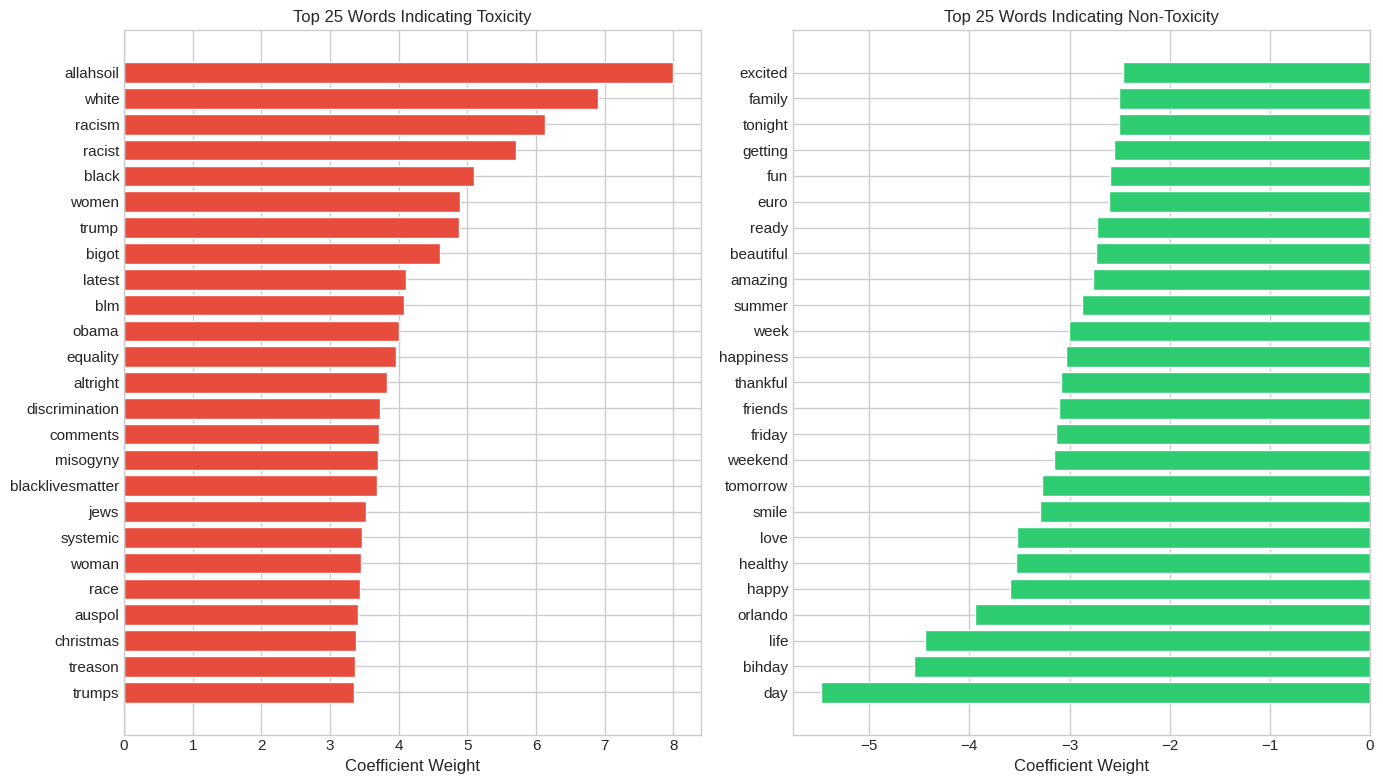

In [32]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = baseline_model.coef_[0]

top_toxic_idx = np.argsort(coefficients)[-25:]
top_nontoxic_idx = np.argsort(coefficients)[:25]

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Toxic indicators
toxic_words = [feature_names[i] for i in top_toxic_idx]
toxic_weights = [coefficients[i] for i in top_toxic_idx]
axes[0].barh(range(len(toxic_words)), toxic_weights, color='#e74c3c')
axes[0].set_yticks(range(len(toxic_words)))
axes[0].set_yticklabels(toxic_words)
axes[0].set_xlabel('Coefficient Weight')
axes[0].set_title('Top 25 Words Indicating Toxicity')

# Non-toxic indicators
nontoxic_words = [feature_names[i] for i in top_nontoxic_idx]
nontoxic_weights = [coefficients[i] for i in top_nontoxic_idx]
axes[1].barh(range(len(nontoxic_words)), nontoxic_weights, color='#2ecc71')
axes[1].set_yticks(range(len(nontoxic_words)))
axes[1].set_yticklabels(nontoxic_words)
axes[1].set_xlabel('Coefficient Weight')
axes[1].set_title('Top 25 Words Indicating Non-Toxicity')

plt.tight_layout()
plt.show()

#### Insights:

-  Dataset is imbalanced
-  Strong ROC-AUC, indicating good overall discrimination
-  Reasonable F1 score given the class imbalance